In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
from tensorflow import keras
from lazypredict.Supervised import LazyClassifier
from underthesea import word_tokenize, pos_tag, sent_tokenize
from pyvi import ViPosTagger, ViTokenizer
import import_ipynb
import Lib.Functions as fc

importing Jupyter notebook from /Users/vuhan/Desktop/JOHN/10. Capstone Project/Week3/Lib/Functions.ipynb


- Đọc dữ liệu:

In [2]:
data = pd.read_csv('data_Foody.csv')

In [3]:
data.head()

,Unnamed: 0,restaurant,review_text,review_score
0,0,Good Morning Restaurant,Pizza phong cách Ý. Ngán hải sản nên cả nhà gh...,8.20
1,1,Hạt Dẻ Trùng Khánh,- Vị trí: chỉ là 1 chiếc xe nho nhỏ nằm ở khu ...,8.00
2,2,Bột - Healthy & Weight Loss Food - Shop Online,Nay lang thang trên BM thấy đang khuyến mãi xo...,8.20
3,3,Bánh Giò Chợ Nguyễn Công Trứ,"Quán nằm trong chợ Nguyễn Công Trứ, cũng dễ tì...",8.20
4,4,Quán Quảng - Bún Quảng,Ngãi heo với heo thiệttttt 🐷🐷🐷\n🤤🤤 bún nem chả...,9.00


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39925 entries, 0 to 39924
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    39925 non-null  int64  
 1   restaurant    39925 non-null  object 
 2   review_text   39925 non-null  object 
 3   review_score  39925 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1.2+ MB


- Ta sẽ xem qua phổ điểm đánh giá của khách hàng trong dataset:

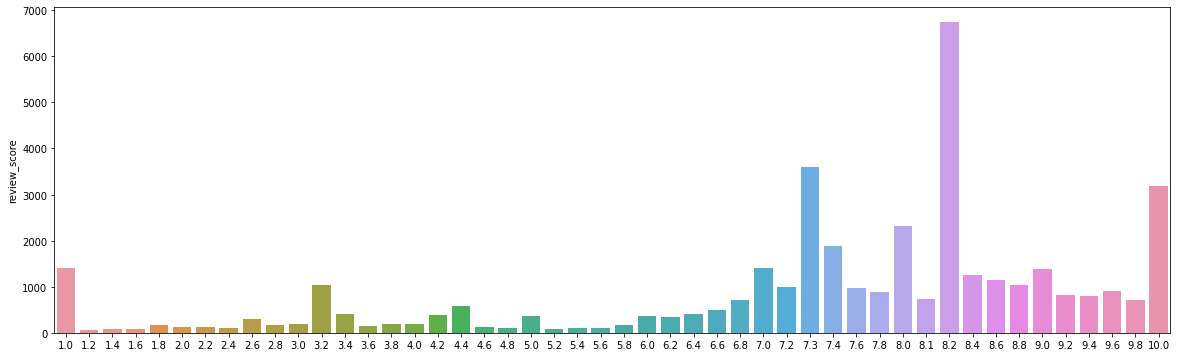

In [5]:
score = data['review_score'].value_counts()
score = pd.DataFrame(score).sort_values(by = 'review_score', ascending = False)

plt.figure(figsize = (20, 6))
sb.barplot(score.index, score['review_score']);

- Dễ dàng nhận thấy điểm số từ 7.0 trở lên chiếm số lượng khá lớn, dựa trên số điểm có thể phỏng đoán các đánh giá thực sự chê hoặc nhận xét không tốt về dịch vụ chiếm số lượng nhỏ hơn các đánh giá tích cực khá nhiều.

- Để xử lý văn bản Tiếng Việt, ta sẽ load một số file dữ liệu cần thiết để làm sạch hoặc thay thế các từ không phải tiếng Việt trong câu: các icon cảm xúc, teencode, các từ dễ nhầm lẫn và stopwords trong tiếng Việt.

In [6]:
# EMOJICON
file = open('files/emojicon.txt', 'r', encoding="utf8")
emoji_lst = file.read().split('\n')
emoji_dict = {}
for line in emoji_lst:
    key, value = line.split('\t')
    emoji_dict[key] = str(value)
file.close()

# TEENCODE
file = open('files/teencode.txt', 'r', encoding="utf8")
teen_lst = file.read().split('\n')
teen_dict = {}
for line in teen_lst:
    key, value = line.split('\t')
    teen_dict[key] = str(value)
file.close()

# TRANSLATE ENGLISH -> VNMESE
file = open('files/english-vnmese.txt', 'r', encoding="utf8")
english_lst = file.read().split('\n')
english_dict = {}
for line in english_lst:
    key, value = line.split('\t')
    english_dict[key] = str(value)
file.close()

# WRONG WORDS
file = open('files/wrong-word.txt', 'r', encoding="utf8")
wrong_lst = file.read().split('\n')
file.close()

# STOPWORDS
file = open('files/vietnamese-stopwords.txt', 'r', encoding="utf8")
stopwords_lst = file.read().split('\n')
file.close()

- Xử lý văn bản tiếng Việt:

In [7]:
import time

t1 = time.time()
final_text = data['review_text'].apply(lambda x: fc.clean_text(x, emoji_dict, teen_dict, wrong_lst, stopwords_lst))
t2 = time.time()

print('Cleaning text took {:.2f} minutes.'.format((t2 - t1) / 60))

Cleaning text took 16.36 minutes.


In [8]:
data['clean_text'] = final_text

In [9]:
data.head()

,Unnamed: 0,restaurant,review_text,review_score,clean_text
0,0,Good Morning Restaurant,Pizza phong cách Ý. Ngán hải sản nên cả nhà gh...,8.20,ngán hải sản ghé ăn. giá rẻ món trình bày đẹp ...
1,1,Hạt Dẻ Trùng Khánh,- Vị trí: chỉ là 1 chiếc xe nho nhỏ nằm ở khu ...,8.00,vị trí ngã sân cát quán phở hoà đông đối diện ...
2,2,Bột - Healthy & Weight Loss Food - Shop Online,Nay lang thang trên BM thấy đang khuyến mãi xo...,8.20,khuyến mãi đọc review thử cảm vị đồ đa đồ siêu...
3,3,Bánh Giò Chợ Nguyễn Công Trứ,"Quán nằm trong chợ Nguyễn Công Trứ, cũng dễ tì...",8.20,quán chợ nguyễn công trứ thẳng chợ tới. quán t...
4,4,Quán Quảng - Bún Quảng,Ngãi heo với heo thiệttttt 🐷🐷🐷\n🤤🤤 bún nem chả...,9.00,ngãi thiệttttt bún chả quảng thơm quán trần vă...


In [10]:
df = data[['clean_text', 'review_score']]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39925 entries, 0 to 39924
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   clean_text    39925 non-null  object 
 1   review_score  39925 non-null  float64
dtypes: float64(1), object(1)
memory usage: 624.0+ KB


- Kiểm tra, loại bỏ dữ liệu trùng cũng như các dòng bị rỗng sau khi xử lý và làm sạch:

In [12]:
dup_val = len(df) - len(df.drop_duplicates())

if dup_val > 0:
    print('Before dropping duplicates: {} rows.'.format(len(df)))
    df = df.drop_duplicates()
    print('After dropping duplicates: {} rows.'.format(len(df)))
else:
    print('No duplicate values.')

Before dropping duplicates: 39925 rows.
After dropping duplicates: 39639 rows.


In [13]:
len(df.loc[df['clean_text'] == ''])

0

- Việc đánh giá và cho điểm của khách hàng dựa khá nhiều vào cảm xúc cũng như nhiều yếu tố khác nhau cộng hưởng đến trải nghiệm dịch vụ. Thực tế từ dữ liệu `review_text` và `score` cho thấy, việc khen chê trong cùng một post đánh giá (review) khá phổ biến, vì như giải thích ở trên, có khá nhiều yếu tố tác động đến trải nghiệm của khách hàng sử dụng dịch vụ như: giá cả, chất lượng, vị trí, phục vụ, thái độ nhân viên, khẩu vị, ... . Vì vậy, trong đa số trường hợp, việc một bình luận của khách hàng không hẳn khớp với mức điểm đánh giá có thể hiểu được bằng việc khách hàng thích điểm này nhưng không thích điểm kia của nhà hàng. Hơn nữa, với những khách hàng khác nhau sẽ có những cảm nhận khác nhau, cách cho điểm đối với từng yếu tố cụ thể giữa hai người cũng sẽ khác nhau.


- Từ những giả định trên, ta sẽ chọn ra một ngưỡng điểm để phân loại các đánh giá và bình luận. Ngưỡng điểm này sẽ không quá cao trên phổ điểm từ 1 - 10, dựa trên những lập luận ở trên. Với các số điểm vượt trên ngưỡng, ta có thể xem nhà hàng được đánh giá có chất lượng ở mức ổn đến tốt, có thể tồn tại cả điểm hài lòng và chưa hài lòng nhưng nhìn chung là đánh giá ổn. Ngược lại, với điểm dưới ngưỡng, có thể xem nhà hàng nhận đánh giá khá tiêu cực và cần nhìn nhận lại cách cung cấp dịch vụ nói chung.


- Ta sẽ chọn ngưỡng điểm là `6` để phân loại các bình luận:

In [14]:
def convert_score(score):
    if score >= 6.0:
        return 'Good'
    else:
        return 'Bad'
    
df['class'] = df.apply(lambda x: convert_score(x['review_score']), axis = 1)

In [15]:
df['class'].value_counts()

Good    32896
Bad      6743
Name: class, dtype: int64

- Các bình luận 'tích cực' chiếm số lượng khá lớn, gần gấp 5 lần các đánh giá tiêu cực.

In [16]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

df['labels'] = encoder.fit_transform(df['class'])

In [17]:
df['labels'].value_counts()

1    32896
0     6743
Name: labels, dtype: int64

- Ta sẽ chuẩn bị dữ liệu cho việc xây dựng mô hình phân loại đánh giá dịch vụ:

In [18]:
X = df.iloc[:, 0]
y = df.iloc[:, -1]

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

Xử lý dữ liệu văn bản bằng lớp `CountVectorizer` của Sklearn và khớp với tập train, test:

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()

X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

Ta sẽ bắt đầu với thuật toán `MultinomialNB` và `BernoulliNB` của lớp `naive_bayes`: 

In [22]:
from sklearn.naive_bayes import MultinomialNB

multiNB = MultinomialNB()
multiNB.fit(X_train_cv, y_train)

print('Train score : {}'.format(multiNB.score(X_train_cv, y_train)))
print('Test score : {}'.format(multiNB.score(X_test_cv, y_test)))

Train score : 0.9252171405917757
Test score : 0.9220484359233098


In [24]:
from sklearn.model_selection import cross_val_score

multiNB_score = cross_val_score(multiNB, X_train_cv, y_train, cv=5)
multiNB_score.mean()

0.9123512750450938

Trung bình kiểm định chéo không khác biệt quá lớn. Tiếp theo, ta sẽ đánh giá mô hình bằng tập test, đồng thời hiển thị các thông số quan trọng trong việc đánh giá bài toán phân loại như 

_confusion matrix, precision_ và _recall_ :


Hàm `eval_clf_testset` đã được viết sẵn trong thư viện Lib, hàm này trả về độ chính xác của mô hình trên tập test, ma trận nhầm lẫn, các giá trị precision, recall và f1-score của từng lớp:

In [25]:
fc.eval_clf_testset(multiNB, X_test_cv, y_test)

----- CLASSIFICATION MODEL PREFOMANCE IN TEST SET-----
* R-squared model of Test: 0.922

* Confusion Matrix of Test: 
[[1448  527]
 [ 400 9517]]

* Classification Report of Test: 
              precision    recall  f1-score   support

           0       0.78      0.73      0.76      1975
           1       0.95      0.96      0.95      9917

    accuracy                           0.92     11892
   macro avg       0.87      0.85      0.86     11892
weighted avg       0.92      0.92      0.92     11892



In [73]:
from sklearn.naive_bayes import BernoulliNB

ber_nb = BernoulliNB()
ber_nb.fit(X_train_cv, y_train)

print('Train score : {}'.format(ber_nb.score(X_train_cv, y_train)))
print('Test score : {}'.format(ber_nb.score(X_test_cv, y_test)))

Train score : 0.9075215338595164
Test score : 0.9047258661284897


In [74]:
fc.eval_clf_testset(ber_nb, X_test_cv, y_test)

----- CLASSIFICATION MODEL PREFOMANCE IN TEST SET-----
* R-squared model of Test: 0.9047

* Confusion Matrix of Test: 
[[1603  372]
 [ 761 9156]]

* Classification Report of Test: 
              precision    recall  f1-score   support

           0       0.68      0.81      0.74      1975
           1       0.96      0.92      0.94      9917

    accuracy                           0.90     11892
   macro avg       0.82      0.87      0.84     11892
weighted avg       0.91      0.90      0.91     11892



In [75]:
ber_score = cross_val_score(ber_nb, X_train_cv, y_train, cv = 5)
ber_score.mean()

0.9034495169164479

Ta sẽ thử phân loại với một thuật toán phổ biến khác sử dụng phương pháp xác suất để phân loại các lớp,

`Logistic Regression`:

In [26]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(random_state = 42)
logit.fit(X_train_cv, y_train)

print('Train score : {}'.format(logit.score(X_train_cv, y_train)))
print('Test score : {}'.format(logit.score(X_test_cv, y_test)))

Train score : 0.9584099181893538
Test score : 0.9273461150353178


In [28]:
logit_score = cross_val_score(logit, X_train_cv, y_train, cv=5)
logit_score.mean()

0.9212171075382465

In [27]:
fc.eval_clf_testset(logit, X_test_cv, y_test)

----- CLASSIFICATION MODEL PREFOMANCE IN TEST SET-----
* R-squared model of Test: 0.9273

* Confusion Matrix of Test: 
[[1441  534]
 [ 330 9587]]

* Classification Report of Test: 
              precision    recall  f1-score   support

           0       0.81      0.73      0.77      1975
           1       0.95      0.97      0.96      9917

    accuracy                           0.93     11892
   macro avg       0.88      0.85      0.86     11892
weighted avg       0.93      0.93      0.93     11892



- Tương tự như `MultinomialNB` và `BernoulliNB`, mô hình `Logistic Regression` có điểm `precision, recall và f1-score` của lớp 0 khá thấp so với lớp 1, điều này có thể do dữ liệu bị lệch giữa 2 class dẫn đến bộ phân loại có hiệu suất ko tốt ở lớp 0.

Các bộ phân loại từ đầu đến giờ đều có một điểm chung là có thể ước tính xác suất của từng lớp, bây giờ ta sẽ huấn luyện với một mô hình mạnh mẽ khác sử dụng các ranh giới để phân loại: `Support Vector Machine`.

Ta sẽ bắt đầu với `SVC`:

In [29]:
from sklearn.svm import SVC

svc = SVC(random_state = 42)
svc.fit(X_train_cv, y_train)

print('Train score : {}'.format(svc.score(X_train_cv, y_train)))
print('Test score : {}'.format(svc.score(X_test_cv, y_test)))

Train score : 0.9556708833387393
Test score : 0.925748402287252


In [31]:
import time

t1 = time.time()
svc_score = cross_val_score(svc, X_train_cv, y_train, cv=5, n_jobs = -1)
t2 = time.time()

print('SVC cross validation took {:.2f} minutes.'.format((t2 - t1) / 60))
print(svc_score.mean())

SVC cross validation took 2.61 minutes.
0.9179374905631889


In [33]:
fc.eval_clf_testset(svc, X_test_cv, y_test)

----- CLASSIFICATION MODEL PREFOMANCE IN TEST SET-----
* R-squared model of Test: 0.9257

* Confusion Matrix of Test: 
[[1280  695]
 [ 188 9729]]

* Classification Report of Test: 
              precision    recall  f1-score   support

           0       0.87      0.65      0.74      1975
           1       0.93      0.98      0.96      9917

    accuracy                           0.93     11892
   macro avg       0.90      0.81      0.85     11892
weighted avg       0.92      0.93      0.92     11892



Ta sẽ thử thêm một mô hình SVM khác cho tác vụ phân loại, lần này là `LinearSVC`, ta cũng sẽ bắt đầu với các tham số mặc định: 

In [34]:
from sklearn.svm import LinearSVC

lin_svc = LinearSVC(random_state = 42)
lin_svc.fit(X_train_cv, y_train)

print('Train score : {}'.format(lin_svc.score(X_train_cv, y_train)))
print('Test score : {}'.format(lin_svc.score(X_test_cv, y_test)))

Train score : 0.9726456914261001
Test score : 0.9129667003027245


In [35]:
lin_svc_score = cross_val_score(lin_svc, X_train_cv, y_train, cv=5)
lin_svc_score.mean()

0.9066928900426827

In [36]:
fc.eval_clf_testset(lin_svc, X_test_cv, y_test)

----- CLASSIFICATION MODEL PREFOMANCE IN TEST SET-----
* R-squared model of Test: 0.913

* Confusion Matrix of Test: 
[[1418  557]
 [ 478 9439]]

* Classification Report of Test: 
              precision    recall  f1-score   support

           0       0.75      0.72      0.73      1975
           1       0.94      0.95      0.95      9917

    accuracy                           0.91     11892
   macro avg       0.85      0.83      0.84     11892
weighted avg       0.91      0.91      0.91     11892



Ta sẽ thử tìm kiếm dạng lưới với mô hình này với hy vọng sẽ cải thiện được các điểm số đánh giá mà ta quan tâm:

In [37]:
from sklearn.model_selection import GridSearchCV

params_lin_svc = [{'loss': ['hinge', 'squared-hinge'], 
                   'C': [1, 10, 100, 1000], 
                   'max_iter': [1000, 5000, 10000],
                   'dual': [True, False]}]

grid_search_lin_svc = GridSearchCV(LinearSVC(random_state = 42), 
                                   params_lin_svc, cv=4, n_jobs = -1)
t1 = time.time()
grid_search_lin_svc.fit(X_train_cv, y_train)
t2 = time.time()

print('Grid Search for LinearSVC took {:.2f} minutes.'.format((t2 - t1) / 60))

Grid Search for LinearSVC took 1.23 minutes.


In [38]:
grid_search_lin_svc.best_params_

{'C': 1, 'dual': True, 'loss': 'hinge', 'max_iter': 1000}

In [40]:
print('Train score : {}'.format(grid_search_lin_svc.score(X_train_cv, y_train)))
print('Test score : {}'.format(grid_search_lin_svc.score(X_test_cv, y_test)))

Train score : 0.9674199012505856
Test score : 0.9203666330306088


In [41]:
lin_svc_gr = cross_val_score(grid_search_lin_svc, X_train_cv, y_train)
lin_svc_gr.mean()

0.9133242869829642

In [87]:
fc.eval_clf_testset(grid_search_lin_svc, X_test_cv, y_test)

----- CLASSIFICATION MODEL PREFOMANCE IN TEST SET-----
* R-squared model of Test: 0.9204

* Confusion Matrix of Test: 
[[1431  544]
 [ 403 9514]]

* Classification Report of Test: 
              precision    recall  f1-score   support

           0       0.78      0.72      0.75      1975
           1       0.95      0.96      0.95      9917

    accuracy                           0.92     11892
   macro avg       0.86      0.84      0.85     11892
weighted avg       0.92      0.92      0.92     11892



Kết quả tương tự như các tham số mặc định, khác biệt nhỏ ở đây là Tìm kiếm dạng lưới cho thấy hàm loss trong `LinearSVC` là __hinge__.

Các mô hình độc lập hoạt động tương đối tốt trên dữ liệu, bây giờ ta sẽ xem các mô hình học _ensemble_ hoạt động ra sao.

Khởi đầu với `RandomForestClassifier` và các tham số mặc định:

In [43]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state = 42)
t1 = time.time()
forest.fit(X_train_cv, y_train)
t2 = time.time()

print('RandomForestClassifier training took {:.3f} minutes.'.format((t2 - t1) / 60))
print('Train score : {}'.format(forest.score(X_train_cv, y_train)))
print('Test score : {}'.format(forest.score(X_test_cv, y_test)))

RandomForestClassifier training took 0.447 minutes.
Train score : 0.9991710815583666
Test score : 0.9159098553649512


In [44]:
forest_score = cross_val_score(forest, X_train_cv, y_train, cv=5)
forest_score.mean()

0.9071615987946858

In [45]:
fc.eval_clf_testset(forest, X_test_cv, y_test)

----- CLASSIFICATION MODEL PREFOMANCE IN TEST SET-----
* R-squared model of Test: 0.9159

* Confusion Matrix of Test: 
[[1090  885]
 [ 115 9802]]

* Classification Report of Test: 
              precision    recall  f1-score   support

           0       0.90      0.55      0.69      1975
           1       0.92      0.99      0.95      9917

    accuracy                           0.92     11892
   macro avg       0.91      0.77      0.82     11892
weighted avg       0.92      0.92      0.91     11892



Mô hình bị overfitting nhẹ và các điểm số đánh giá có vẻ khá thấp nếu so với các kết quả có được từ các mô hình phía trên. 

Ta sẽ dùng Tìm kiếm dạng lưới để tinh chỉnh các Siêu tham số với hy vọng mô hình sẽ hoạt động tốt hơn: 

In [46]:
params_forest = {'n_estimators': [90, 120, 150],
                'bootstrap': [True, False], 
                'max_depth': [1, 3, 5, 7, None]}

grid_search_forest = GridSearchCV(RandomForestClassifier(random_state = 42), params_forest, cv=4)
t1 = time.time()
grid_search_forest.fit(X_train_cv, y_train)
t2 = time.time()

print('Grid Search RandomForestClassifier took {:.2f} minutes.'.format((t2 - t1) / 60))

Grid Search RandomForestClassifier took 20.38 minutes.


In [47]:
grid_search_forest.best_params_

{'bootstrap': False, 'max_depth': None, 'n_estimators': 150}

In [48]:
print('Train score : {}'.format(grid_search_forest.score(X_train_cv, y_train)))
print('Test score : {}'.format(grid_search_forest.score(X_test_cv, y_test)))

Train score : 0.9991710815583666
Test score : 0.9166666666666666


In [50]:
fc.eval_clf_testset(grid_search_forest, X_test_cv, y_test)

----- CLASSIFICATION MODEL PREFOMANCE IN TEST SET-----
* R-squared model of Test: 0.9167

* Confusion Matrix of Test: 
[[1126  849]
 [ 142 9775]]

* Classification Report of Test: 
              precision    recall  f1-score   support

           0       0.89      0.57      0.69      1975
           1       0.92      0.99      0.95      9917

    accuracy                           0.92     11892
   macro avg       0.90      0.78      0.82     11892
weighted avg       0.91      0.92      0.91     11892



Kết quả có vẻ không khả quan hơn so với các tham số mặc định.

Một lựa chọn khác cho việc sử dụng Cây Quyết định trong lớp _ensemble_ của Sklearn là mô hình Cây Siêu ngẫu nhiên `ExtraTreesClassifier`

`ExtraTreesClassifier` sử dụng ngưỡng ngẫu nhiên đối với từng đặc trưng thay vì tìm kiếm các ngưỡng tốt nhất nên thời gian chạy thuật toán sẽ rút ngắn so với `Decision Tree`:

In [51]:
from sklearn.ensemble import ExtraTreesClassifier

trees = ExtraTreesClassifier(n_estimators = 120, random_state = 42)
t1 = time.time()
trees.fit(X_train_cv, y_train)
t2 = time.time()

print('ExtraTreesClassifier training took {:.2f} minutes.'.format((t2 - t1) / 60))
print('Train score : {}'.format(trees.score(X_train_cv, y_train)))
print('Test score : {}'.format(trees.score(X_test_cv, y_test)))

ExtraTreesClassifier training took 3.81 minutes.
Train score : 0.9991710815583666
Test score : 0.9162462159434914


In [52]:
trees_score = cross_val_score(trees, X_train_cv, y_train, cv=5)
trees_score.mean()

0.9074858711658136

In [53]:
fc.eval_clf_testset(trees, X_test_cv, y_test)

----- CLASSIFICATION MODEL PREFOMANCE IN TEST SET-----
* R-squared model of Test: 0.9162

* Confusion Matrix of Test: 
[[1110  865]
 [ 131 9786]]

* Classification Report of Test: 
              precision    recall  f1-score   support

           0       0.89      0.56      0.69      1975
           1       0.92      0.99      0.95      9917

    accuracy                           0.92     11892
   macro avg       0.91      0.77      0.82     11892
weighted avg       0.91      0.92      0.91     11892



- Hiệu suất của Cây siêu ngẫu nhiên khá tương đồng với Rừng ngẫu nhiên: phân loại khá kém ở lớp 0.



- Ta sẽ thử một thuật toán khác trong lớp _ensemble_: `XGBoost`

In [54]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(random_state = 42)
xgb_clf.fit(X_train_cv, y_train)

print('Train score : {}'.format(xgb_clf.score(X_train_cv, y_train)))
print('Test score : {}'.format(xgb_clf.score(X_test_cv, y_test)))

Train score : 0.9526074890979205
Test score : 0.9289438277833838


In [55]:
xgb_clf_score = cross_val_score(xgb_clf, X_train_cv, y_train)
xgb_clf_score.mean()

0.9197033797177967

In [56]:
fc.eval_clf_testset(xgb_clf, X_test_cv, y_test)

----- CLASSIFICATION MODEL PREFOMANCE IN TEST SET-----
* R-squared model of Test: 0.9289

* Confusion Matrix of Test: 
[[1377  598]
 [ 247 9670]]

* Classification Report of Test: 
              precision    recall  f1-score   support

           0       0.85      0.70      0.77      1975
           1       0.94      0.98      0.96      9917

    accuracy                           0.93     11892
   macro avg       0.89      0.84      0.86     11892
weighted avg       0.93      0.93      0.93     11892



`XGBoost` khớp dữ liệu tương đối tốt, các chỉ số metrics ở lớp 0 được cải thiện tốt hơn so với các thuật toán cùng lớp phía trên.

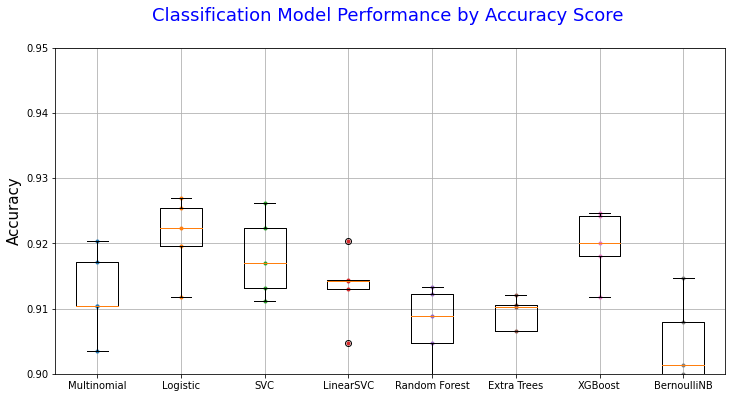

In [79]:
plt.figure(figsize = (12, 6))
plt.plot([1] * 5, multiNB_score, '.')
plt.plot([2] * 5, logit_score, '.')
plt.plot([3] * 5, svc_score, '.')
plt.plot([4] * 5, lin_svc_gr, '.')
plt.plot([5] * 5, forest_score, '.')
plt.plot([6] * 5, trees_score, '.')
plt.plot([7] * 5, xgb_clf_score, '.')
plt.plot([8] * 5, ber_score, '.')

plt.boxplot([multiNB_score, logit_score, svc_score, lin_svc_gr, 
             forest_score, trees_score, xgb_clf_score, ber_score],
           labels = ['Multinomial', 'Logistic', 'SVC', 'LinearSVC', 
                     'Random Forest', 'Extra Trees', 'XGBoost', 'BernoulliNB'])
plt.ylabel('Accuracy', fontsize = 15)
plt.ylim([0.90, 0.95])
plt.grid(True)
plt.title('Classification Model Performance by Accuracy Score \n', fontsize = 18, color = 'b');

Biểu đồ trên đánh giá độ chính xác trên 5 fold kiểm định chéo trên tập huấn luyện.  Nhìn chung, các bộ phân loại mà ta sử dụng hoạt động khá tốt trên tập huấn luyện, độ chính xác >= 90%. Có thể thấy các bộ phân loại đơn lẻ hoạt động tốt hơn một chút so với các bộ phân loại kết hợp.


Việc chọn ra một thuật toán phân loại tốt nhất cho tập huấn luyện trên có vẻ hơi khó khăn một chút, vì các chỉ số đánh giá một bộ phân loại mà ta quan tâm trong trường hợp này không hẳn chỉ dựa trên _accuracy score_. Việc quan tâm đến _precision, recall, f1-score_ trên từng lớp sẽ cho cái nhìn tổng quát hơn.


Một cách tiếp cận cho trường hợp này là kết hợp các bộ phân loại với nhau thành một bộ phân loại biểu quyết. Điều này có vẻ khả thi vì trên cùng một bộ dữ liệu, ta đã huấn luyện 8 bộ phân loại độc lập khác nhau, điều này làm tăng khả năng các bộ phân loại này mắc phải những lỗi rất khác nhau. Việc kết hợp các bộ phân loại này thành một bộ phân loại ___ensemble___ có thể cải thiện độ chính xác và các chỉ số đánh giá khác.


Ta sẽ xây dựng một bộ phân loại biểu quyết với các mô hình dự đoán phía trên kèm theo các siêu tham số đã được tinh chỉnh của chúng. Để rút ngắn thời gian huấn luyện và tăng hiệu quả cho bộ phân loại biểu quyết, ta sẽ chỉ lựa chọn các bộ phân loại có độ chính xác trên 5 fold kiểm định chéo đều từ 0.91 trở lên: `Logistic Regression, SVC, XGBoost` được lựa chọn.


Bắt đầu với `Voting Classifier` trong lớp _ensemble_ của Sklearn:

In [62]:
from sklearn.ensemble import VotingClassifier

multiNB = MultinomialNB()
logit_clf = LogisticRegression(random_state = 42)
svc = SVC(probability = True, random_state = 42)
lin_svc = LinearSVC(loss = 'hinge', random_state = 42)
forest_clf = RandomForestClassifier(random_state = 42)
trees_clf = ExtraTreesClassifier(random_state = 42)
xgb_clf = xgb.XGBClassifier(random_state = 42)

named_estimators = [
#                     ('multiNB', multiNB),
                    ('logit_clf', logit_clf),
                    ('svc', svc),
#                     ('lin_svc', lin_svc),
#                     ('forest_clf', forest_clf),
#                     ('trees_clf', trees_clf),
                    ('xgb_clf', xgb_clf)
                    ]

voting_clf = VotingClassifier(named_estimators)
t1 = time.time()
voting_clf.fit(X_train_cv, y_train)
t2 = time.time()

print('Voting Classifier training took {:.2f} minutes.'.format((t2 - t1) / 60))

Voting Classifier training took 30.84 minutes.


In [63]:
voting_clf.score(X_train_cv, y_train)

0.9581576386636393

In [64]:
t1 = time.time()
voting_clf_score = cross_val_score(voting_clf, X_train_cv, y_train, cv=5)
t2 = time.time()

print('Voting Score: {}'.format(voting_clf_score.mean()))
print('Voting Classifier cross-validation took {:.2f} minutes.'.format((t2 - t1) / 60))

Voting Score: 0.925433817309831
Voting Classifier cross-validation took 41.39 minutes.


Trung bình điểm số đánh giá trên 5 fold cao hơn hẳn so với bất kỳ bộ phân loại nào trước đó.

Ta sẽ xem mô hình hoạt động ra sao trên tập kiểm tra:

In [65]:
fc.eval_clf_testset(voting_clf, X_test_cv, y_test)

----- CLASSIFICATION MODEL PREFOMANCE IN TEST SET-----
* R-squared model of Test: 0.9338

* Confusion Matrix of Test: 
[[1390  585]
 [ 202 9715]]

* Classification Report of Test: 
              precision    recall  f1-score   support

           0       0.87      0.70      0.78      1975
           1       0.94      0.98      0.96      9917

    accuracy                           0.93     11892
   macro avg       0.91      0.84      0.87     11892
weighted avg       0.93      0.93      0.93     11892



- Các chỉ số đánh giá trên tập kiểm tra có cải thiện hơn so với các bộ phân loại trước đó.

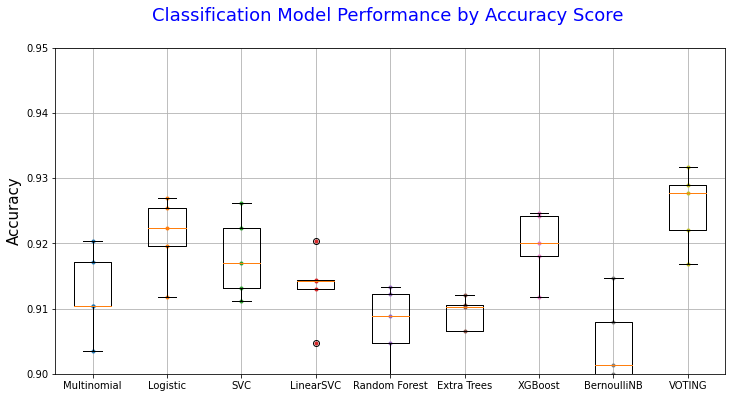

In [162]:
plt.figure(figsize = (12, 6))
plt.plot([1] * 5, multiNB_score, '.')
plt.plot([2] * 5, logit_score, '.')
plt.plot([3] * 5, svc_score, '.')
plt.plot([4] * 5, lin_svc_gr, '.')
plt.plot([5] * 5, forest_score, '.')
plt.plot([6] * 5, trees_score, '.')
plt.plot([7] * 5, xgb_clf_score, '.')
plt.plot([8] * 5, ber_score, '.')
plt.plot([9] * 5, voting_clf_score, '.')
plt.boxplot([multiNB_score, logit_score, svc_score, lin_svc_gr, 
             forest_score, trees_score, xgb_clf_score, ber_score, voting_clf_score],
           labels = ['Multinomial', 'Logistic', 'SVC', 'LinearSVC', 
                     'Random Forest', 'Extra Trees', 'XGBoost', 'BernoulliNB', 'VOTING'])
plt.ylabel('Accuracy', fontsize = 15)
plt.ylim([0.90, 0.95])
plt.grid(True)
plt.title('Classification Model Performance by Accuracy Score \n', fontsize = 18, color = 'b');

Bộ phân loại biểu quyết có thể là mô hình phân loại khá ổn cho đến thời điểm này.

Bộ phân loại biểu quyết mà ta đang sử dụng dựa trên biểu quyết cứng _(hard voting)_. Ta sẽ thay đổi thành bộ biểu quyết mềm _(soft voting)_ với hy vọng độ chính xác sẽ cải thiện hơn:

- _Soft voting_ thường đạt chất lượng cao hơn vì sử dụng phương thức ước tính xác suất của từng lớp, đồng thời, các biểu quyết có độ tin cậy cao  sẽ được gán trọng số lớn hơn.
- Các bộ phân loại ta đã sử dụng mặc định đều có phương thức `predict_proba`, ngoại trừ `SVC`. Đối với `SVC`, ta sẽ chỉnh tham số `probability = True` để có phương thức ước tính xác suất các lớp, đánh đổi bằng thời gian huấn luyện lâu hơn.

In [67]:
named_estimators1 = [
#                     ('multiNB', multiNB),
                    ('logit_clf', logit_clf),
                    ('svc', svc),
#                     ('lin_svc', lin_svc),
#                     ('forest_clf', forest_clf),
#                     ('trees_clf', trees_clf),
                    ('xgb_clf', xgb_clf)
                    ]



voting_modified = VotingClassifier(named_estimators1)
t1 = time.time()
voting_modified.fit(X_train_cv, y_train)
t2 = time.time()

print('Voting Modified training took {:.2f}s.'.format(t2 - t1))

Voting Modified training took 750.04s.


Mô hình biểu quyết này vẫn là ___hard voting___ , ta sẽ so sánh với ___soft voting___ :

In [68]:
t1 = time.time()
hard_score = cross_val_score(voting_modified, X_train_cv, y_train)
t2 = time.time()
print('Hard Voting score: {:.2f}'.format(hard_score.mean()))
print('Hard Voting time: {:.2f} minutes.'.format((t2 - t1) / 60))

Hard Voting score: 0.93
Hard Voting time: 26.89 minutes.


In [69]:
fc.eval_clf_testset(voting_modified, X_test_cv, y_test)

----- CLASSIFICATION MODEL PREFOMANCE IN TEST SET-----
* R-squared model of Test: 0.9338

* Confusion Matrix of Test: 
[[1390  585]
 [ 202 9715]]

* Classification Report of Test: 
              precision    recall  f1-score   support

           0       0.87      0.70      0.78      1975
           1       0.94      0.98      0.96      9917

    accuracy                           0.93     11892
   macro avg       0.91      0.84      0.87     11892
weighted avg       0.93      0.93      0.93     11892



Bây giờ ta sẽ đổi thành bộ phân loại biểu quyết ___soft voting___ :

In [70]:
voting_modified.voting = 'soft'

In [95]:
t1 = time.time()
soft_score = cross_val_score(voting_modified, X_train_cv, y_train)
t2 = time.time()
print('Soft Voting score: {:.2f}'.format(soft_score.mean()))
print('Soft Voting time: {:.2f} minutes.'.format((t2 - t1) / 60))

Soft Voting score: 0.93
Soft Voting time: 20.14 minutes.


In [72]:
fc.eval_clf_testset(voting_modified, X_test_cv, y_test)

----- CLASSIFICATION MODEL PREFOMANCE IN TEST SET-----
* R-squared model of Test: 0.9342

* Confusion Matrix of Test: 
[[1441  534]
 [ 249 9668]]

* Classification Report of Test: 
              precision    recall  f1-score   support

           0       0.85      0.73      0.79      1975
           1       0.95      0.97      0.96      9917

    accuracy                           0.93     11892
   macro avg       0.90      0.85      0.87     11892
weighted avg       0.93      0.93      0.93     11892



Kiểm định chéo với ___soft voting___ cho kết quả tương đương so với ___hard voting___, tuy nhiên thời gian xử lý ngắn hơn. Ta sẽ dùng bộ phân loại biểu quyết với phương thức `soft voting` để lưu model và đánh giá trên dữ liệu mới.

Ta sẽ dùng một cách tiếp cận khác cho việc phân loại, đó là sử dụng mạng `Neural Network` với lớp _Embedding_ cho việc xử lý ngôn ngữ tự nhiên, mạng tích chập 1 chiều và LSTM 2 chiều.

In [82]:
vocab_size = 1200
max_length = 150
embedding_dim = 64
oov_tok = '<OOV>'
padding_type = 'post'
trunc_type = 'post'

- Xử lý ngôn ngữ tự nhiên với lớp `Tokenizer`:

In [83]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

train_sequence = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequence, maxlen = max_length, padding = padding_type, truncating = trunc_type)

valid_sequence = tokenizer.texts_to_sequences(X_test)
valid_padded = pad_sequences(valid_sequence, maxlen = max_length, padding = padding_type, truncating = trunc_type)

Bắt đầu phân loại với lớp `GlobalAveragePooling1D`:

In [84]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

history = model.fit(train_padded, y_train,
                    validation_data = (valid_padded, y_test),
                    epochs = 150,
                    verbose = 2)

Epoch 1/150
868/868 - 2s - loss: 0.2769 - accuracy: 0.8912 - val_loss: 0.1949 - val_accuracy: 0.9250 - 2s/epoch - 2ms/step
Epoch 2/150
868/868 - 1s - loss: 0.1837 - accuracy: 0.9297 - val_loss: 0.1887 - val_accuracy: 0.9273 - 1s/epoch - 1ms/step
Epoch 3/150
868/868 - 1s - loss: 0.1755 - accuracy: 0.9331 - val_loss: 0.1809 - val_accuracy: 0.9318 - 1s/epoch - 1ms/step
Epoch 4/150
868/868 - 1s - loss: 0.1675 - accuracy: 0.9347 - val_loss: 0.1750 - val_accuracy: 0.9337 - 1s/epoch - 1ms/step
Epoch 5/150
868/868 - 1s - loss: 0.1620 - accuracy: 0.9375 - val_loss: 0.1842 - val_accuracy: 0.9288 - 1s/epoch - 1ms/step
Epoch 6/150
868/868 - 1s - loss: 0.1574 - accuracy: 0.9386 - val_loss: 0.1931 - val_accuracy: 0.9203 - 1s/epoch - 2ms/step
Epoch 7/150
868/868 - 2s - loss: 0.1545 - accuracy: 0.9397 - val_loss: 0.1813 - val_accuracy: 0.9325 - 2s/epoch - 2ms/step
Epoch 8/150
868/868 - 1s - loss: 0.1497 - accuracy: 0.9400 - val_loss: 0.1865 - val_accuracy: 0.9319 - 1s/epoch - 1ms/step
Epoch 9/150
868/

Epoch 68/150
868/868 - 1s - loss: 0.0330 - accuracy: 0.9875 - val_loss: 1.0536 - val_accuracy: 0.9132 - 1s/epoch - 1ms/step
Epoch 69/150
868/868 - 1s - loss: 0.0293 - accuracy: 0.9886 - val_loss: 1.0681 - val_accuracy: 0.9135 - 1s/epoch - 1ms/step
Epoch 70/150
868/868 - 1s - loss: 0.0291 - accuracy: 0.9890 - val_loss: 1.0094 - val_accuracy: 0.8962 - 1s/epoch - 1ms/step
Epoch 71/150
868/868 - 1s - loss: 0.0316 - accuracy: 0.9877 - val_loss: 1.1180 - val_accuracy: 0.9120 - 1s/epoch - 1ms/step
Epoch 72/150
868/868 - 1s - loss: 0.0285 - accuracy: 0.9880 - val_loss: 1.1296 - val_accuracy: 0.9141 - 1s/epoch - 1ms/step
Epoch 73/150
868/868 - 1s - loss: 0.0265 - accuracy: 0.9894 - val_loss: 1.1482 - val_accuracy: 0.9123 - 1s/epoch - 1ms/step
Epoch 74/150
868/868 - 1s - loss: 0.0288 - accuracy: 0.9885 - val_loss: 1.1658 - val_accuracy: 0.9131 - 1s/epoch - 1ms/step
Epoch 75/150
868/868 - 1s - loss: 0.0264 - accuracy: 0.9894 - val_loss: 1.1674 - val_accuracy: 0.9121 - 1s/epoch - 1ms/step
Epoch 76

Epoch 134/150
868/868 - 1s - loss: 0.0159 - accuracy: 0.9939 - val_loss: 1.4465 - val_accuracy: 0.9097 - 1s/epoch - 1ms/step
Epoch 135/150
868/868 - 1s - loss: 0.0150 - accuracy: 0.9939 - val_loss: 1.5984 - val_accuracy: 0.9160 - 1s/epoch - 1ms/step
Epoch 136/150
868/868 - 1s - loss: 0.0182 - accuracy: 0.9929 - val_loss: 1.5161 - val_accuracy: 0.9084 - 1s/epoch - 1ms/step
Epoch 137/150
868/868 - 1s - loss: 0.0196 - accuracy: 0.9928 - val_loss: 1.5064 - val_accuracy: 0.9101 - 1s/epoch - 1ms/step
Epoch 138/150
868/868 - 1s - loss: 0.0145 - accuracy: 0.9940 - val_loss: 1.5491 - val_accuracy: 0.9115 - 1s/epoch - 1ms/step
Epoch 139/150
868/868 - 1s - loss: 0.0152 - accuracy: 0.9938 - val_loss: 1.5362 - val_accuracy: 0.9133 - 1s/epoch - 1ms/step
Epoch 140/150
868/868 - 1s - loss: 0.0188 - accuracy: 0.9924 - val_loss: 1.4498 - val_accuracy: 0.9087 - 1s/epoch - 1ms/step
Epoch 141/150
868/868 - 1s - loss: 0.0168 - accuracy: 0.9935 - val_loss: 1.4885 - val_accuracy: 0.9063 - 1s/epoch - 1ms/step


Ta sẽ dùng Mạng tích chập 1 chiều với `MaxPooling1D` với hy vọng sẽ cải thiện accuracy ở tập test:

In [85]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Conv1D(32, 3, activation = 'relu'),
    tf.keras.layers.MaxPooling1D(pool_size = 2, strides = 1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

history = model.fit(train_padded, y_train,
                    validation_data = (valid_padded, y_test),
                    epochs = 150,
                    verbose = 2)

Epoch 1/150
868/868 - 8s - loss: 0.2428 - accuracy: 0.9022 - val_loss: 0.2043 - val_accuracy: 0.9225 - 8s/epoch - 9ms/step
Epoch 2/150
868/868 - 8s - loss: 0.1711 - accuracy: 0.9357 - val_loss: 0.1861 - val_accuracy: 0.9286 - 8s/epoch - 9ms/step
Epoch 3/150
868/868 - 7s - loss: 0.1467 - accuracy: 0.9448 - val_loss: 0.1987 - val_accuracy: 0.9273 - 7s/epoch - 8ms/step
Epoch 4/150
868/868 - 7s - loss: 0.1213 - accuracy: 0.9544 - val_loss: 0.1922 - val_accuracy: 0.9279 - 7s/epoch - 8ms/step
Epoch 5/150
868/868 - 7s - loss: 0.0941 - accuracy: 0.9649 - val_loss: 0.2287 - val_accuracy: 0.9268 - 7s/epoch - 8ms/step
Epoch 6/150
868/868 - 7s - loss: 0.0722 - accuracy: 0.9713 - val_loss: 0.2804 - val_accuracy: 0.9222 - 7s/epoch - 8ms/step
Epoch 7/150
868/868 - 7s - loss: 0.0564 - accuracy: 0.9777 - val_loss: 0.3151 - val_accuracy: 0.9193 - 7s/epoch - 8ms/step
Epoch 8/150
868/868 - 7s - loss: 0.0464 - accuracy: 0.9823 - val_loss: 0.3648 - val_accuracy: 0.9206 - 7s/epoch - 8ms/step
Epoch 9/150
868/

Epoch 68/150
868/868 - 7s - loss: 0.0111 - accuracy: 0.9957 - val_loss: 0.7429 - val_accuracy: 0.9192 - 7s/epoch - 8ms/step
Epoch 69/150
868/868 - 7s - loss: 0.0085 - accuracy: 0.9966 - val_loss: 0.7557 - val_accuracy: 0.9188 - 7s/epoch - 8ms/step
Epoch 70/150
868/868 - 7s - loss: 0.0088 - accuracy: 0.9961 - val_loss: 0.8276 - val_accuracy: 0.9215 - 7s/epoch - 8ms/step
Epoch 71/150
868/868 - 7s - loss: 0.0084 - accuracy: 0.9965 - val_loss: 0.9054 - val_accuracy: 0.9209 - 7s/epoch - 8ms/step
Epoch 72/150
868/868 - 7s - loss: 0.0102 - accuracy: 0.9961 - val_loss: 0.8688 - val_accuracy: 0.9200 - 7s/epoch - 8ms/step
Epoch 73/150
868/868 - 7s - loss: 0.0088 - accuracy: 0.9963 - val_loss: 0.7855 - val_accuracy: 0.9165 - 7s/epoch - 8ms/step
Epoch 74/150
868/868 - 7s - loss: 0.0091 - accuracy: 0.9963 - val_loss: 0.9057 - val_accuracy: 0.9180 - 7s/epoch - 8ms/step
Epoch 75/150
868/868 - 7s - loss: 0.0099 - accuracy: 0.9963 - val_loss: 0.9637 - val_accuracy: 0.9182 - 7s/epoch - 8ms/step
Epoch 76

Epoch 134/150
868/868 - 7s - loss: 0.0081 - accuracy: 0.9968 - val_loss: 1.0042 - val_accuracy: 0.9212 - 7s/epoch - 8ms/step
Epoch 135/150
868/868 - 7s - loss: 0.0070 - accuracy: 0.9971 - val_loss: 1.0769 - val_accuracy: 0.9235 - 7s/epoch - 8ms/step
Epoch 136/150
868/868 - 7s - loss: 0.0076 - accuracy: 0.9970 - val_loss: 0.9652 - val_accuracy: 0.9217 - 7s/epoch - 8ms/step
Epoch 137/150
868/868 - 7s - loss: 0.0070 - accuracy: 0.9970 - val_loss: 1.0846 - val_accuracy: 0.9221 - 7s/epoch - 8ms/step
Epoch 138/150
868/868 - 7s - loss: 0.0069 - accuracy: 0.9970 - val_loss: 1.1022 - val_accuracy: 0.9239 - 7s/epoch - 8ms/step
Epoch 139/150
868/868 - 7s - loss: 0.0082 - accuracy: 0.9967 - val_loss: 1.0593 - val_accuracy: 0.9234 - 7s/epoch - 8ms/step
Epoch 140/150
868/868 - 7s - loss: 0.0063 - accuracy: 0.9974 - val_loss: 1.0534 - val_accuracy: 0.9217 - 7s/epoch - 9ms/step
Epoch 141/150
868/868 - 7s - loss: 0.0067 - accuracy: 0.9972 - val_loss: 1.1050 - val_accuracy: 0.9220 - 7s/epoch - 8ms/step


Độ chính xác ở tập kiểm tra đã cải thiện hơn so với mô hình trước.


Ta sẽ điều chuẩn mô hình với một số thay đổi ở hàm kích hoạt và kernel:

In [92]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Conv1D(64, 5, activation = 'relu'),
    tf.keras.layers.MaxPooling1D(pool_size = 2, strides = 1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation = 'elu', kernel_initializer = 'he_normal'),
    tf.keras.layers.Dense(16, activation = 'elu', kernel_initializer = 'he_normal'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

history = model.fit(train_padded, y_train,
                    validation_data = (valid_padded, y_test),
                    epochs = 150,
                    verbose = 2)

Epoch 1/150
868/868 - 14s - loss: 0.2249 - accuracy: 0.9099 - val_loss: 0.1783 - val_accuracy: 0.9332 - 14s/epoch - 16ms/step
Epoch 2/150
868/868 - 13s - loss: 0.1642 - accuracy: 0.9358 - val_loss: 0.1763 - val_accuracy: 0.9331 - 13s/epoch - 15ms/step
Epoch 3/150
868/868 - 12s - loss: 0.1284 - accuracy: 0.9500 - val_loss: 0.1879 - val_accuracy: 0.9300 - 12s/epoch - 14ms/step
Epoch 4/150
868/868 - 12s - loss: 0.0844 - accuracy: 0.9672 - val_loss: 0.2468 - val_accuracy: 0.9225 - 12s/epoch - 14ms/step
Epoch 5/150
868/868 - 13s - loss: 0.0542 - accuracy: 0.9795 - val_loss: 0.3011 - val_accuracy: 0.9199 - 13s/epoch - 15ms/step
Epoch 6/150
868/868 - 13s - loss: 0.0423 - accuracy: 0.9844 - val_loss: 0.3450 - val_accuracy: 0.9246 - 13s/epoch - 14ms/step
Epoch 7/150
868/868 - 13s - loss: 0.0371 - accuracy: 0.9853 - val_loss: 0.3536 - val_accuracy: 0.9208 - 13s/epoch - 15ms/step
Epoch 8/150
868/868 - 13s - loss: 0.0306 - accuracy: 0.9885 - val_loss: 0.3908 - val_accuracy: 0.9195 - 13s/epoch - 15

Epoch 66/150
868/868 - 14s - loss: 0.0075 - accuracy: 0.9971 - val_loss: 1.0777 - val_accuracy: 0.9170 - 14s/epoch - 16ms/step
Epoch 67/150
868/868 - 14s - loss: 0.0085 - accuracy: 0.9967 - val_loss: 1.0119 - val_accuracy: 0.9200 - 14s/epoch - 16ms/step
Epoch 68/150
868/868 - 14s - loss: 0.0078 - accuracy: 0.9966 - val_loss: 0.9083 - val_accuracy: 0.9192 - 14s/epoch - 16ms/step
Epoch 69/150
868/868 - 13s - loss: 0.0074 - accuracy: 0.9969 - val_loss: 0.9952 - val_accuracy: 0.9195 - 13s/epoch - 15ms/step
Epoch 70/150
868/868 - 13s - loss: 0.0075 - accuracy: 0.9970 - val_loss: 1.1263 - val_accuracy: 0.9163 - 13s/epoch - 15ms/step
Epoch 71/150
868/868 - 13s - loss: 0.0083 - accuracy: 0.9965 - val_loss: 0.9636 - val_accuracy: 0.9166 - 13s/epoch - 14ms/step
Epoch 72/150
868/868 - 13s - loss: 0.0064 - accuracy: 0.9972 - val_loss: 1.1119 - val_accuracy: 0.9171 - 13s/epoch - 15ms/step
Epoch 73/150
868/868 - 13s - loss: 0.0085 - accuracy: 0.9966 - val_loss: 0.9239 - val_accuracy: 0.9193 - 13s/ep

Epoch 131/150
868/868 - 12s - loss: 0.0051 - accuracy: 0.9976 - val_loss: 1.7616 - val_accuracy: 0.9166 - 12s/epoch - 14ms/step
Epoch 132/150
868/868 - 12s - loss: 0.0070 - accuracy: 0.9972 - val_loss: 1.2354 - val_accuracy: 0.9178 - 12s/epoch - 14ms/step
Epoch 133/150
868/868 - 12s - loss: 0.0062 - accuracy: 0.9974 - val_loss: 1.4341 - val_accuracy: 0.9177 - 12s/epoch - 14ms/step
Epoch 134/150
868/868 - 13s - loss: 0.0060 - accuracy: 0.9973 - val_loss: 1.3642 - val_accuracy: 0.9125 - 13s/epoch - 14ms/step
Epoch 135/150
868/868 - 13s - loss: 0.0060 - accuracy: 0.9973 - val_loss: 1.5355 - val_accuracy: 0.9090 - 13s/epoch - 15ms/step
Epoch 136/150
868/868 - 12s - loss: 0.0068 - accuracy: 0.9973 - val_loss: 1.2618 - val_accuracy: 0.9163 - 12s/epoch - 14ms/step
Epoch 137/150
868/868 - 12s - loss: 0.0052 - accuracy: 0.9976 - val_loss: 1.6951 - val_accuracy: 0.9152 - 12s/epoch - 14ms/step
Epoch 138/150
868/868 - 12s - loss: 0.0055 - accuracy: 0.9975 - val_loss: 1.8126 - val_accuracy: 0.9115 

In [91]:
from sklearn.metrics import classification_report

yhat = model.predict(valid_padded)
yhat = np.round(yhat).reshape(-1)

print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.80      0.71      0.75      1975
           1       0.94      0.96      0.95      9917

    accuracy                           0.92     11892
   macro avg       0.87      0.84      0.85     11892
weighted avg       0.92      0.92      0.92     11892



Ta sẽ phân loại với `LSTM` 2 chiều và lớp _fully connected_ có điều chuẩn:

In [96]:
model_lstm = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation = 'elu', kernel_initializer = 'he_normal'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_lstm.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

history = model_lstm.fit(train_padded, y_train,
                    validation_data = (valid_padded, y_test),
                    epochs = 150,
                    verbose = 2)

Epoch 1/150
868/868 - 39s - loss: 0.2317 - accuracy: 0.9108 - val_loss: 0.1840 - val_accuracy: 0.9312 - 39s/epoch - 45ms/step
Epoch 2/150
868/868 - 40s - loss: 0.1794 - accuracy: 0.9329 - val_loss: 0.1855 - val_accuracy: 0.9276 - 40s/epoch - 46ms/step
Epoch 3/150
868/868 - 43s - loss: 0.1637 - accuracy: 0.9383 - val_loss: 0.1859 - val_accuracy: 0.9309 - 43s/epoch - 50ms/step
Epoch 4/150
868/868 - 39s - loss: 0.1479 - accuracy: 0.9440 - val_loss: 0.1890 - val_accuracy: 0.9303 - 39s/epoch - 45ms/step
Epoch 5/150
868/868 - 39s - loss: 0.1379 - accuracy: 0.9477 - val_loss: 0.1934 - val_accuracy: 0.9287 - 39s/epoch - 45ms/step
Epoch 6/150
868/868 - 39s - loss: 0.1271 - accuracy: 0.9527 - val_loss: 0.1982 - val_accuracy: 0.9260 - 39s/epoch - 45ms/step
Epoch 7/150
868/868 - 39s - loss: 0.1175 - accuracy: 0.9555 - val_loss: 0.2087 - val_accuracy: 0.9235 - 39s/epoch - 45ms/step
Epoch 8/150
868/868 - 40s - loss: 0.1051 - accuracy: 0.9602 - val_loss: 0.2372 - val_accuracy: 0.9255 - 40s/epoch - 46

Epoch 66/150
868/868 - 42s - loss: 0.0088 - accuracy: 0.9967 - val_loss: 0.6914 - val_accuracy: 0.9101 - 42s/epoch - 48ms/step
Epoch 67/150
868/868 - 43s - loss: 0.0103 - accuracy: 0.9960 - val_loss: 0.6339 - val_accuracy: 0.9106 - 43s/epoch - 49ms/step
Epoch 68/150
868/868 - 42s - loss: 0.0115 - accuracy: 0.9961 - val_loss: 0.5901 - val_accuracy: 0.9114 - 42s/epoch - 48ms/step
Epoch 69/150
868/868 - 43s - loss: 0.0089 - accuracy: 0.9966 - val_loss: 0.6500 - val_accuracy: 0.9125 - 43s/epoch - 49ms/step
Epoch 70/150
868/868 - 42s - loss: 0.0074 - accuracy: 0.9970 - val_loss: 0.6826 - val_accuracy: 0.9030 - 42s/epoch - 48ms/step
Epoch 71/150
868/868 - 43s - loss: 0.0095 - accuracy: 0.9965 - val_loss: 0.6703 - val_accuracy: 0.9094 - 43s/epoch - 49ms/step
Epoch 72/150
868/868 - 43s - loss: 0.0071 - accuracy: 0.9972 - val_loss: 0.7067 - val_accuracy: 0.9087 - 43s/epoch - 49ms/step
Epoch 73/150
868/868 - 44s - loss: 0.0103 - accuracy: 0.9961 - val_loss: 0.6097 - val_accuracy: 0.9112 - 44s/ep

Epoch 131/150
868/868 - 43s - loss: 0.0052 - accuracy: 0.9978 - val_loss: 0.7135 - val_accuracy: 0.9112 - 43s/epoch - 49ms/step
Epoch 132/150
868/868 - 44s - loss: 0.0058 - accuracy: 0.9974 - val_loss: 0.6892 - val_accuracy: 0.9124 - 44s/epoch - 51ms/step
Epoch 133/150
868/868 - 42s - loss: 0.0070 - accuracy: 0.9971 - val_loss: 0.6354 - val_accuracy: 0.9100 - 42s/epoch - 48ms/step
Epoch 134/150
868/868 - 42s - loss: 0.0067 - accuracy: 0.9973 - val_loss: 0.6901 - val_accuracy: 0.9088 - 42s/epoch - 48ms/step
Epoch 135/150
868/868 - 43s - loss: 0.0060 - accuracy: 0.9975 - val_loss: 0.6617 - val_accuracy: 0.9152 - 43s/epoch - 49ms/step
Epoch 136/150
868/868 - 44s - loss: 0.0062 - accuracy: 0.9976 - val_loss: 0.6709 - val_accuracy: 0.9147 - 44s/epoch - 51ms/step
Epoch 137/150
868/868 - 45s - loss: 0.0053 - accuracy: 0.9978 - val_loss: 0.6990 - val_accuracy: 0.9141 - 45s/epoch - 52ms/step
Epoch 138/150
868/868 - 48s - loss: 0.0050 - accuracy: 0.9977 - val_loss: 0.7025 - val_accuracy: 0.9152 

In [97]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Conv1D(32, 3, activation = 'relu'),
    tf.keras.layers.MaxPooling1D(pool_size = 2, strides = 1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(24, activation = 'elu', kernel_initializer = 'he_normal'),
    tf.keras.layers.Dense(16, activation = 'elu', kernel_initializer = 'he_normal'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

history = model.fit(train_padded, y_train,
                    validation_data = (valid_padded, y_test),
                    epochs = 150,
                    verbose = 2)

Epoch 1/150
868/868 - 10s - loss: 0.2408 - accuracy: 0.9034 - val_loss: 0.1777 - val_accuracy: 0.9330 - 10s/epoch - 11ms/step
Epoch 2/150
868/868 - 8s - loss: 0.1737 - accuracy: 0.9337 - val_loss: 0.1756 - val_accuracy: 0.9328 - 8s/epoch - 9ms/step
Epoch 3/150
868/868 - 8s - loss: 0.1549 - accuracy: 0.9400 - val_loss: 0.1809 - val_accuracy: 0.9324 - 8s/epoch - 9ms/step
Epoch 4/150
868/868 - 8s - loss: 0.1347 - accuracy: 0.9479 - val_loss: 0.1854 - val_accuracy: 0.9326 - 8s/epoch - 9ms/step
Epoch 5/150
868/868 - 8s - loss: 0.1151 - accuracy: 0.9546 - val_loss: 0.2084 - val_accuracy: 0.9304 - 8s/epoch - 9ms/step
Epoch 6/150
868/868 - 8s - loss: 0.0968 - accuracy: 0.9612 - val_loss: 0.2240 - val_accuracy: 0.9252 - 8s/epoch - 9ms/step
Epoch 7/150
868/868 - 8s - loss: 0.0847 - accuracy: 0.9678 - val_loss: 0.2497 - val_accuracy: 0.9269 - 8s/epoch - 9ms/step
Epoch 8/150
868/868 - 8s - loss: 0.0763 - accuracy: 0.9716 - val_loss: 0.2542 - val_accuracy: 0.9248 - 8s/epoch - 9ms/step
Epoch 9/150
8

868/868 - 8s - loss: 0.0179 - accuracy: 0.9929 - val_loss: 0.5850 - val_accuracy: 0.9232 - 8s/epoch - 9ms/step
Epoch 68/150
868/868 - 8s - loss: 0.0202 - accuracy: 0.9924 - val_loss: 0.5433 - val_accuracy: 0.9240 - 8s/epoch - 9ms/step
Epoch 69/150
868/868 - 8s - loss: 0.0196 - accuracy: 0.9926 - val_loss: 0.5290 - val_accuracy: 0.9248 - 8s/epoch - 9ms/step
Epoch 70/150
868/868 - 8s - loss: 0.0178 - accuracy: 0.9930 - val_loss: 0.4664 - val_accuracy: 0.9230 - 8s/epoch - 9ms/step
Epoch 71/150
868/868 - 8s - loss: 0.0207 - accuracy: 0.9920 - val_loss: 0.5061 - val_accuracy: 0.9231 - 8s/epoch - 9ms/step
Epoch 72/150
868/868 - 8s - loss: 0.0187 - accuracy: 0.9924 - val_loss: 0.5613 - val_accuracy: 0.9223 - 8s/epoch - 9ms/step
Epoch 73/150
868/868 - 8s - loss: 0.0180 - accuracy: 0.9931 - val_loss: 0.5314 - val_accuracy: 0.9246 - 8s/epoch - 9ms/step
Epoch 74/150
868/868 - 8s - loss: 0.0194 - accuracy: 0.9926 - val_loss: 0.5522 - val_accuracy: 0.9235 - 8s/epoch - 9ms/step
Epoch 75/150
868/868 

Epoch 133/150
868/868 - 8s - loss: 0.0138 - accuracy: 0.9944 - val_loss: 0.5907 - val_accuracy: 0.9245 - 8s/epoch - 9ms/step
Epoch 134/150
868/868 - 8s - loss: 0.0151 - accuracy: 0.9937 - val_loss: 0.5624 - val_accuracy: 0.9239 - 8s/epoch - 9ms/step
Epoch 135/150
868/868 - 8s - loss: 0.0136 - accuracy: 0.9944 - val_loss: 0.6109 - val_accuracy: 0.9236 - 8s/epoch - 9ms/step
Epoch 136/150
868/868 - 8s - loss: 0.0128 - accuracy: 0.9948 - val_loss: 0.7503 - val_accuracy: 0.9221 - 8s/epoch - 9ms/step
Epoch 137/150
868/868 - 8s - loss: 0.0136 - accuracy: 0.9947 - val_loss: 0.6023 - val_accuracy: 0.9257 - 8s/epoch - 9ms/step
Epoch 138/150
868/868 - 8s - loss: 0.0147 - accuracy: 0.9943 - val_loss: 0.6104 - val_accuracy: 0.9242 - 8s/epoch - 9ms/step
Epoch 139/150
868/868 - 8s - loss: 0.0158 - accuracy: 0.9940 - val_loss: 0.5597 - val_accuracy: 0.9236 - 8s/epoch - 9ms/step
Epoch 140/150
868/868 - 8s - loss: 0.0134 - accuracy: 0.9944 - val_loss: 0.5946 - val_accuracy: 0.9237 - 8s/epoch - 9ms/step


- Nhận xét:

    Mô hình mạng neural với lớp `Conv1D` và `MaxPooling1D` kèm điều chuẩn cho hiệu suất khá tốt và thời gian nhanh hơn các mô hình còn lại, kể cả `Voting Classifier` phía trên.
    
    Đề xuất lựa chọn mô hình mạng neural với lớp `Conv1D` và `MaxPooling1D` kèm điều chuẩn để lưu mô hình và dự đoán.

In [146]:
yhat = model.predict(valid_padded)
yhat = np.round(yhat).reshape(-1)

print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.80      0.72      0.76      1975
           1       0.95      0.96      0.95      9917

    accuracy                           0.92     11892
   macro avg       0.87      0.84      0.86     11892
weighted avg       0.92      0.92      0.92     11892



In [156]:
model.save('Foody_review_analysis.h5')
print('Saved !!!')

Saved !!!


In [142]:
text = ['đồ ăn tạm tàm nhưng nhân viên thái độ lồi lõm, đúng là một lần và mãi mãi', 
        'quán dở bà cố mà review ảo tung chảo',
        'Có ngon gì đâu mà review cao ngất ngưởng',
        'Nguyên liệu cũ để lâu ngày',
        'Quán xập xệ, nóng bức làm ăn mất cả ngon',
        'Chưa nói đến đồ ăn có ngon hay không, quán sát bờ sông mà chỉ xài đèn cầy, đi với anh người eo cả buổi cứ gãi sồn sột mất hết cả hình ảnh duyên đánh, thanh lịch của mị',
        'Đồ ăn không ngon được cái anh chủ quán đẹp trai nhưng anh lại có vợ',
        ]

In [141]:
review = 'đồ ăn tạm tàm nhưng nhân viên thái độ lồi lõm, đúng là một lần và mãi mãi'

In [135]:
final_text = fc.clean_text(text, emoji_dict, teen_dict, wrong_lst, stopwords_lst)
final_text

In [150]:
proceed_text = [fc.clean_text(x, emoji_dict, teen_dict, wrong_lst, stopwords_lst) for x in text]

In [151]:
proceed_text

['đồ tạm tàm nhân viên thái độ lồi lõm mãi mãi.',
 'quán dở cố review ảo chảo.',
 'review ngất ngưởng.',
 'nguyên liệu cũ ngày.',
 'quán xập xệ nóng .',
 'đồ không quán sát bờ sông xài đèn cầy gãi sồn sột hình ảnh duyên đánh lịch mị.',
 'đồ không chủ quán đẹp vợ.']

In [153]:
def predict_review(text):
    new_sequence = tokenizer.texts_to_sequences(text)
    new_padded = pad_sequences(new_sequence,
                               padding = padding_type,
                               truncating = trunc_type,
                               maxlen = max_length)
    return new_padded

In [154]:
new_text = predict_review(proceed_text)

In [155]:
np.argmax(model.predict(new_text), axis=-1)

array([0, 0, 0, 0, 0, 0, 0])

In [147]:
review_cv = cv.transform(pd.Series(data = text))

In [148]:
voting_modified.predict(review_cv)

array([0, 0, 0, 1, 1, 0, 1])

In [149]:
xgb_model = xgb_clf.fit(X_train_cv, y_train)
xgb_clf.predict(review_cv)

array([0, 0, 1, 1, 1, 0, 1])

In [158]:
# from sklearn.base import BaseEstimator, TransformerMixin

# class ReplaceByAvg(BaseEstimator, TransformerMixin):
#     def __init__(self, list_col):
#         self.list_col = list_col
#     def fit(self, X, y = None):
#         return self
#     def transform(self, df):
#         X = df.copy()
#         for col in self.list_col:
#             X.loc[X[col] == 0, col] = round(X[col].mean(), 2)
#         return X

In [159]:
a = [data['review_text'][4]]
a

['Ngãi heo với heo thiệttttt 🐷🐷🐷\n🤤🤤 bún nem chả gì gì của Quảng - bao ngon, bao thơm, bao no 🤤🤤\n quán này ở trần văn khéo .Kế sò ốc 99. Quán quảng. Mình ăn rất vừa miệng. Thịt nướng mềm. Nước chấm vừa ăn. Do mình ko thích ăn dầu mỡ nhìu nên chả giò rán nó mình ăn ko nhìu. Nhưng ko ngấy. Mỗi khúc chả đều có tôm nguyên con. Nhưng nếu lột vỏ tôm hả bỏ vào chả giò thì ổn hơn. 😌']

In [160]:
pred_text = predict_review(a)
np.argmax(model.predict(pred_text), axis = -1)

array([0])